In [1]:
from manifold_learning.data.data_loader import load_csv_dataset
from manifold_learning import IMD, IMD_
import importlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
importlib.reload(IMD)
importlib.reload(IMD_)

<module 'manifold_learning.IMD_' from '/home/iaroslav/Documents/Python projects/manifold_learning/src/manifold_learning/IMD_.py'>

In [2]:
X = load_csv_dataset("CellCycle4X.csv").to_numpy().T#[:,1:]

In [3]:
trainer = IMD.IMD_nD(X.shape[1], embed_dim=3, n_components=3,learning_rate=0.001, device="cuda",optimizer="Adam",random_state=2)

In [44]:
trainer = IMD_.IMD_nD(X.shape[1], embed_dim=3, n_components=3,learning_rate=0.001, device="cuda",optimizer="Adam",random_state=2)

In [4]:
trainer.fit(X, sample_len=300, library_len=800, nbrs_num=15, tp=60, epochs=100, num_batches=32)


RuntimeError: cannot reshape tensor of 0 elements into shape [-1, 0, 3, 3] because the unspecified dimension size -1 can be any value and is ambiguous

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import os
import imageio

output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

for i in range(1000):
    trainer.fit(X, sample_len=300, library_len=800, nbrs_num=15, tp=60, epochs=1, num_batches=32)

    ax = plt.figure(figsize=(5, 5),dpi=200).add_subplot(projection='3d')
    ax.plot(*trainer.predict(X)[:, 0].T, lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")

    plt.savefig(f"{output_dir}/frame_{i:02d}.png")
    plt.close()

#with imageio.get_writer('animation.gif', mode='I', duration=0.25) as writer:
with imageio.get_writer('animation_adam.mp4', mode='I') as writer:
    for i in range(1000):
        filename = f"{output_dir}/frame_{i:02d}.png"
        image = imageio.imread(filename)
        writer.append_data(image)


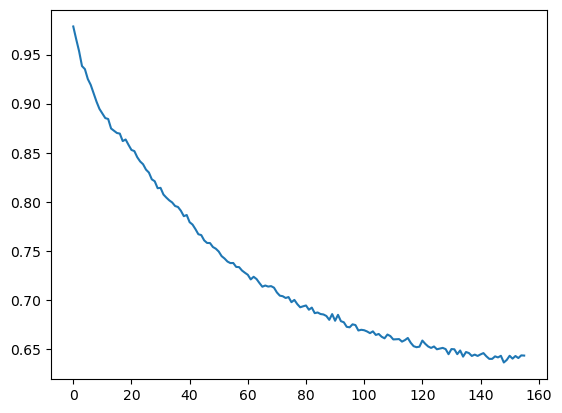

In [92]:
plt.plot(trainer.get_loss_history()[:])

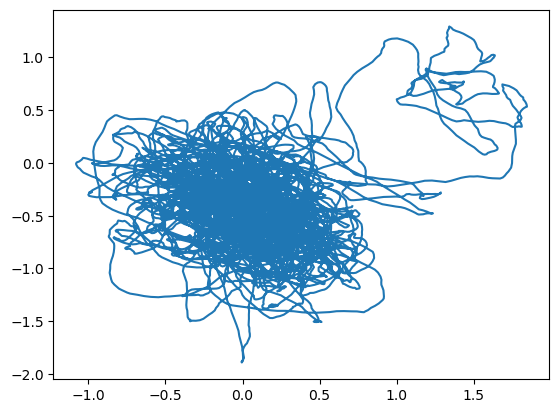

In [94]:
plt.plot(trainer.predict(X)[:,0,0],trainer.predict(X)[:,0,1])


Epoch 1/1, Loss: 1.2013
Epoch 1/1, Loss: 1.1830
Epoch 1/1, Loss: 1.1592
Epoch 1/1, Loss: 1.1415
Epoch 1/1, Loss: 1.1306
Epoch 1/1, Loss: 1.1107
Epoch 1/1, Loss: 1.1021
Epoch 1/1, Loss: 1.0915
Epoch 1/1, Loss: 1.0762
Epoch 1/1, Loss: 1.0621


KeyboardInterrupt: 

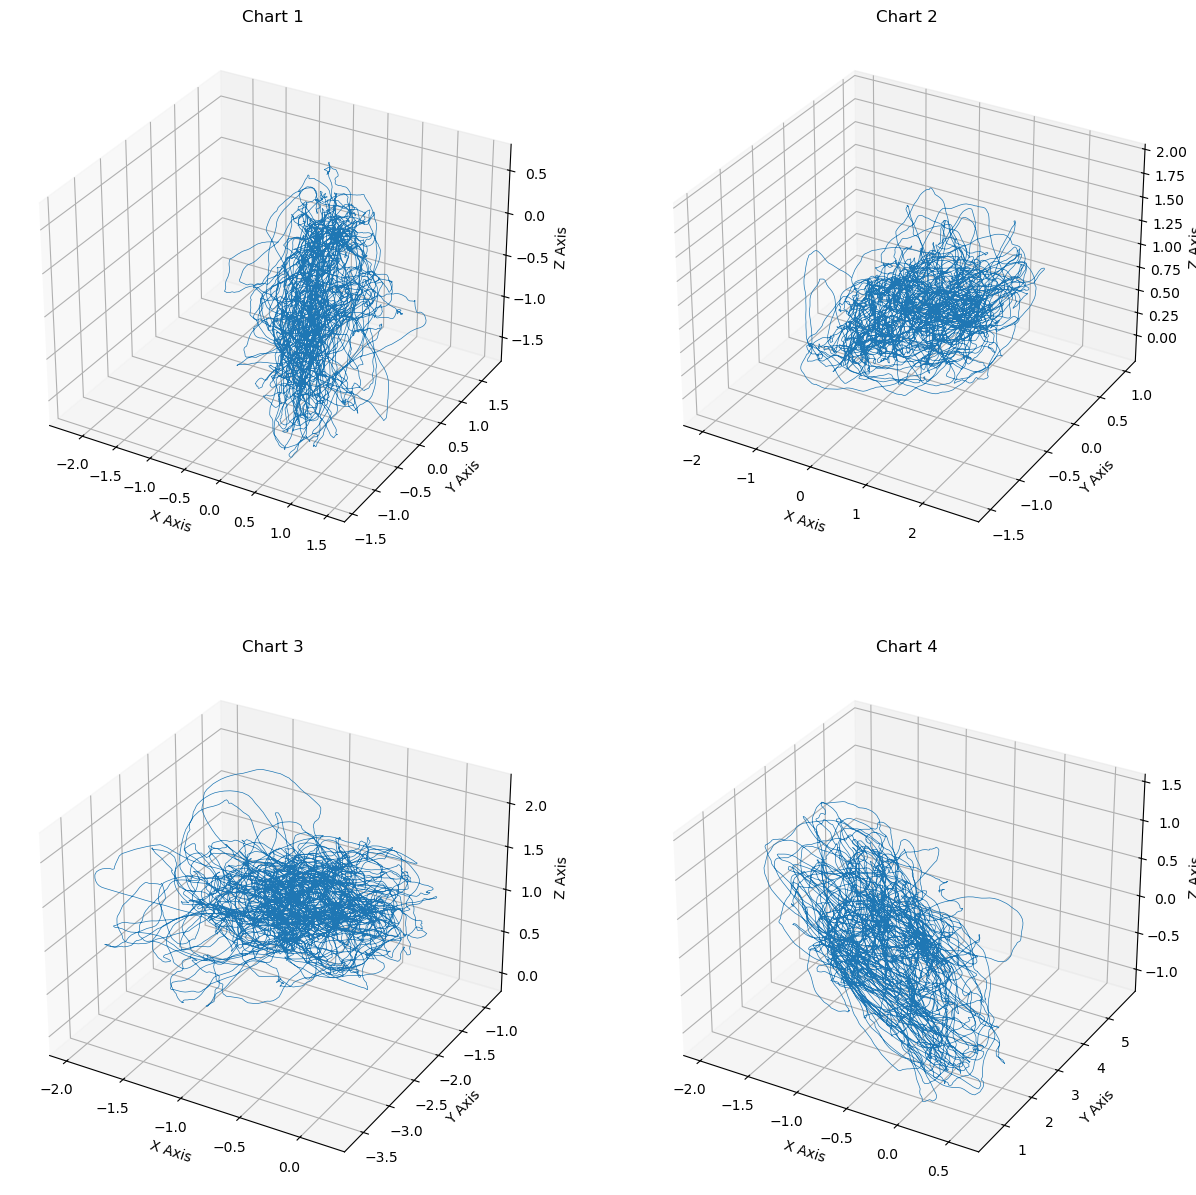

In [97]:
from mpl_toolkits.mplot3d import Axes3D
import os
import imageio
import matplotlib.pyplot as plt

# Assuming trainer is defined and has the 'fit' and 'predict' methods
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

# Generate and save frames for the single figure with 4 subplots
for i in range(1000):
    trainer.fit(X, sample_len=200, library_len=700, nbrs_num=15, tp=50, epochs=1, num_batches=32)
    xx = trainer.predict(X)

    fig, axs = plt.subplots(2, 2, figsize=(15, 15), subplot_kw={'projection': '3d'})
    titles = ["Chart 1", "Chart 2", "Chart 3", "Chart 4"]

    for j, ax in enumerate(axs.flat):
        ax.plot(*xx[:, j].T, lw=0.5)
        ax.set_xlabel("X Axis")
        ax.set_ylabel("Y Axis")
        ax.set_zlabel("Z Axis")
        ax.set_title(titles[j])

    plt.savefig(f"{output_dir}/frame_{i:02d}.png")
    plt.close(fig)

# Create a video file from the saved frames
with imageio.get_writer('animation_4_charts3.mp4', mode='I') as writer:
    for i in range(1000):
        filename = f"{output_dir}/frame_{i:02d}.png"
        image = imageio.imread(filename)
        writer.append_data(image)
